<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/USE_finetuning_YouTube_clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Check GPU, if assigned k8 then factory reset couple of times until we get Tesla GPU
!nvidia-smi

Mon Jul 19 07:00:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 4.3MB 9.4MB/s 
     |████████████████████████████████| 1.6MB 9.2MB/s 
     |████████████████████████████████| 358kB 51.0MB/s 
     |████████████████████████████████| 686kB 50.4MB/s 
     |████████████████████████████████| 37.2MB 70kB/s 
     |████████████████████████████████| 215kB 49.8MB/s 
     |████████████████████████████████| 1.2MB 51.7MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 645kB 45.1MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 


#Imports

In [5]:
import os, math
import numpy as np
import pandas as pd
import requests
import shutil
import re
from pathlib import Path
import random
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization


from tensorflow import keras
from official.nlp import optimization  # to create AdamW optmizer
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

tf.get_logger().setLevel('ERROR')

import sys

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')
from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [6]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


#Configs

##Sentence encoder configs

In [7]:
encoder = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')
USE_layer = hub.KerasLayer(
    encoder,
    input_shape=[],
    dtype=tf.string, 
    trainable=True, name='USE_embedding')

##General config

In [8]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
stop_clickbait_tfrecFiles_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/Stop_clickbait/tfrec_data/'

model_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/saved_models'
saved_model_name = f'youtube_clickbait_finetuned_USE'
saved_model_path = os.path.join(model_root_path, saved_model_name )

checkpoint_root_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/checkpoints'
model_checkpoint_path = os.path.join(checkpoint_root_path, f'youtube_clickbait_finetuned_USE_checkpoint' )


BATCH_SIZE = 32  
# Label categories
label_list = [0,1]

init_lr = 2e-3

epochs = 5

#Scripts

In [9]:
#@title "Utilities [TF Dataset]"
def read_tfrecord(example):
    features = {
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return text, class_num, label

def load_dataset(filenames):
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(dataset, train=False):
  if train:
    dataset = dataset.shuffle(num_train_examples)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.cache().prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  return dataset

In [10]:
#@title "Utilities [Create Model Definition]"
def create_model():

 model = tf.keras.models.Sequential()
 model.add(USE_layer)
 model.add(tf.keras.layers.Dropout(0.1))
 model.add(tf.keras.layers.Dense(128, activation='relu'))
 model.add(tf.keras.layers.Dropout(0.1))
 model.add(tf.keras.layers.Dense(64, activation='relu'))
 model.add(tf.keras.layers.Dropout(0.1))
 model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 return model

In [11]:
#@title "Utilities [Model prediction]"
def get_metrics(y_test, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(y_test, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(y_test, y_pred)
    print(matrix)

def predict_on_test_dataset(model, test_data, BATCH_SIZE=32):
  y_true=[]
  
  for text_feat, labels in test_data:
    for i in range(BATCH_SIZE):
      y_true.append(labels[i].numpy())


  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  vh.plot_cm(y_true, predicted_scores)
  print()

In [12]:
#@title "Utilities [Visualization]"
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#Read TFRecord data

In [13]:
#@title  "Load files & Split"
#instantiate read_data utility
read_YouTube_data = read_tfrec_data(tfrec_trainVal_files_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

read_stop_clickbait_data = read_tfrec_data(stop_clickbait_tfrecFiles_path, VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
YouTube_filenames, YouTube_training_filenames, YouTube_validation_filenames, YouTube_testing_filenames = read_YouTube_data.get_tfrec_files()

stop_clickbait_filenames, stop_clickbait_training_filenames,stop_clickbait_validation_filenames, stop_clickbait_testing_filenames = read_stop_clickbait_data.get_tfrec_files()

filenames = YouTube_filenames + stop_clickbait_filenames
training_filenames = YouTube_training_filenames + stop_clickbait_training_filenames
validation_filenames = YouTube_validation_filenames + stop_clickbait_validation_filenames

random.shuffle(filenames)
random.shuffle(training_filenames)
random.shuffle(validation_filenames)

#len(filenames), len(training_filenames), len(validation_filenames)

num_train_examples = 974 * len(YouTube_training_filenames) + 500 * len(stop_clickbait_training_filenames)
num_total_examples = 974 * len(YouTube_filenames) + 500 * len(stop_clickbait_filenames)

validation_steps = int(num_total_examples  // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(num_total_examples  // len(filenames) * len(training_filenames)) // BATCH_SIZE

num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))



Pattern matches 14 data files. Splitting dataset into 12 training files , 2 validation files and 0 test files
Pattern matches 64 data files. Splitting dataset into 52 training files , 12 validation files and 0 test files
With a batch size of 32, there will be 1170 batches per training epoch and 255 batch(es) per validation run.


In [14]:
#instantiate read_data utility for test set
read_test_data = read_tfrec_data(tfrec_test_files_path, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=1)

# splitting data files between training, validation and test
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
len(testing_filenames)

Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files


2

#Load TFRecord into TF Dataset

In [15]:
# create the datasets
with tf.device('/cpu:0'):
  train_ds = load_dataset(training_filenames)
  val_ds = load_dataset(validation_filenames)
  test_ds = load_dataset(testing_filenames)

In [16]:
for i,(text, class_num, label) in enumerate(train_ds.take(10)):
  print(f"text : {text.numpy()}, class : {class_num.numpy()}, label : {label.numpy()}")

text : b'lula s future in the hands of brazilian parliament', class : 0, label : b'nonclickbaits'
text : b'cricket england defeats india in fourth one day international', class : 0, label : b'nonclickbaits'
text : b'new record time spent in space', class : 0, label : b'nonclickbaits'
text : b'jeremy tyler n b a prospect is groomed to play his own way', class : 0, label : b'nonclickbaits'
text : b'a woman s viral video of her heartbreaking experience with a cashier isn t true wal mart says', class : 1, label : b'clickbaits'
text : b'years of international herald tribune articles disappear', class : 0, label : b'nonclickbaits'
text : b'how you act around your friends vs your best friend', class : 1, label : b'clickbaits'
text : b'the inadi and wikimedia argentina sign an agreement of cooperation', class : 0, label : b'nonclickbaits'
text : b'mauritania cuts ties with israel expels israeli diplomats', class : 0, label : b'nonclickbaits'
text : b'the hardest beatles song title quiz you ll 

In [17]:
with tf.device('/cpu:0'):
  train_ds = train_ds.map(lambda text, class_num, label:(text, class_num))
  val_ds = val_ds.map(lambda text, class_num, label:(text, class_num))
  test_ds = test_ds.map(lambda text, class_num, label:(text, class_num))

In [18]:
with tf.device('/cpu:0'):
  train_ds = get_batched_dataset(train_ds, train=True)
  val_ds = get_batched_dataset(val_ds)
  test_ds = get_batched_dataset(test_ds)

#Modeling

In [19]:
# train data spec
train_ds.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

##Build classifier

In [20]:
classifier_model = create_model()
classifier_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE_embedding (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

##Train classifier model

###Compile model

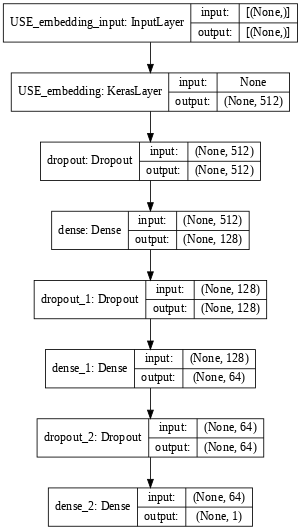

In [21]:
es = tf.keras.callbacks.EarlyStopping(
          monitor='val_loss', 
          verbose=1, 
          patience=5, 
          mode='min', 
          restore_best_weights=True
          )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=model_checkpoint_path,
         save_weights_only=True,
         monitor='val_prc',
         mode='max',
         verbose=1,
         save_best_only=True
        )

METRICS = [
             keras.metrics.TruePositives(name='tp'),
             keras.metrics.FalsePositives(name='fp'),
             keras.metrics.TrueNegatives(name='tn'),
             keras.metrics.FalseNegatives(name='fn'), 
             keras.metrics.BinaryAccuracy(name='accuracy'),
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc'),
             keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
      )

classifier_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(), 
    metrics=METRICS
    )

tf.keras.utils.plot_model(model=classifier_model, show_shapes=True, dpi=60)

In [22]:
#@title Load weights if available
if os.path.exists(model_checkpoint_path):
  print('loading saved weight')
  classifier_model.load_weights(model_checkpoint_path)
else:
  print('No weight to initialize')

No weight to initialize


###Train

In [26]:
history = classifier_model.fit(
             x=train_ds,
             validation_data=val_ds,
             epochs=epochs,
             validation_steps=50,
             callbacks=[es, mcb]
             )

Epoch 1/5
1176/1176 [==============================] - 236s 201ms/step - loss: 0.0045 - tp: 18376.0000 - fp: 32.0000 - tn: 19207.0000 - fn: 17.0000 - accuracy: 0.9987 - precision: 0.9983 - recall: 0.9991 - auc: 0.9998 - prc: 0.9997 - val_loss: 0.0966 - val_tp: 1477.0000 - val_fp: 39.0000 - val_tn: 1647.0000 - val_fn: 37.0000 - val_accuracy: 0.9762 - val_precision: 0.9743 - val_recall: 0.9756 - val_auc: 0.9923 - val_prc: 0.9902

Epoch 00001: val_prc did not improve from 0.99703
Epoch 2/5
1176/1176 [==============================] - 235s 200ms/step - loss: 0.0019 - tp: 18389.0000 - fp: 17.0000 - tn: 19222.0000 - fn: 4.0000 - accuracy: 0.9994 - precision: 0.9991 - recall: 0.9998 - auc: 0.9999 - prc: 0.9999 - val_loss: 0.1325 - val_tp: 1479.0000 - val_fp: 37.0000 - val_tn: 1649.0000 - val_fn: 35.0000 - val_accuracy: 0.9775 - val_precision: 0.9756 - val_recall: 0.9769 - val_auc: 0.9875 - val_prc: 0.9832

Epoch 00002: val_prc did not improve from 0.99703
Epoch 3/5
1176/1176 [================

In [27]:
# Save model weights
classifier_model.save_weights(model_checkpoint_path)

#Plot train history

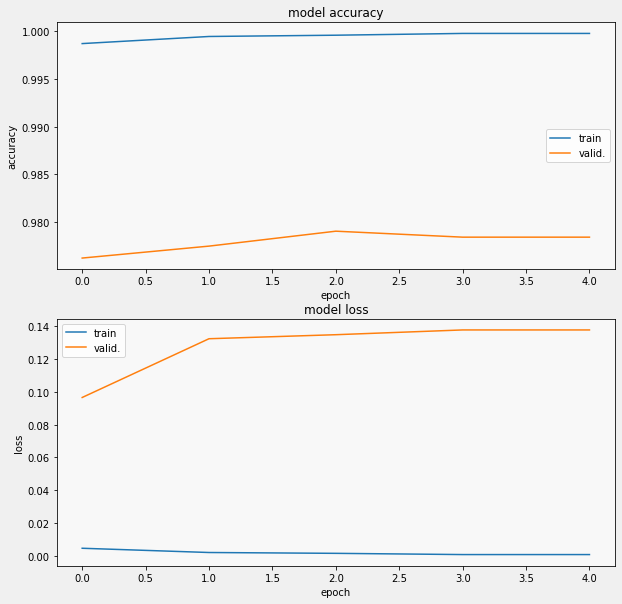

In [28]:
vh.display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
vh.display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

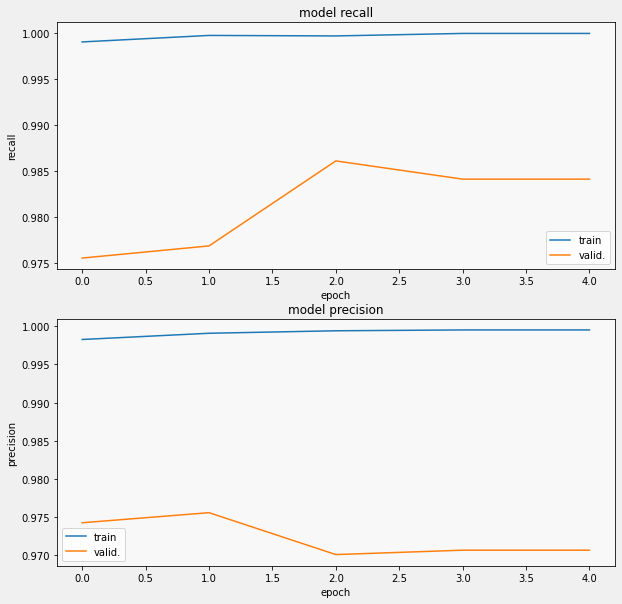

In [29]:
vh.display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
vh.display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Evaluate model

In [30]:
results = classifier_model.evaluate(test_ds)

for name, value in zip(classifier_model.metrics_names, results):
  print(name, ': ', value)
print()

60/60 [==============================] - 4s 50ms/step - loss: 0.1532 - tp: 876.0000 - fp: 39.0000 - tn: 984.0000 - fn: 21.0000 - accuracy: 0.9688 - precision: 0.9574 - recall: 0.9766 - auc: 0.9862 - prc: 0.9825
loss :  0.15319065749645233
tp :  876.0
fp :  39.0
tn :  984.0
fn :  21.0
accuracy :  0.96875
precision :  0.9573770761489868
recall :  0.9765886068344116
auc :  0.9862292408943176
prc :  0.9825041890144348



#Export for inference

In [31]:
classifier_model.save(saved_model_path, include_optimizer=False)

#Model prediction

In [32]:
saved_classifier = keras.models.load_model(saved_model_path)

Accuracy: 0.968750
Precision: 0.957377
Recall: 0.976589
F1 score: 0.966887
ROC AUC: 0.969233
[[984  39]
 [ 21 876]]
Non clickbaits Detected (True Negatives):  984
Non-Clickbaits Detected as Clickbaits (False Positives):  39
Clickbaits Detected as Non-clickbaits (False Negatives):  21
Clickbaits Detected (True Positives):  876
Total Non-clickbaits:  1023
Total Clickbaits:  897



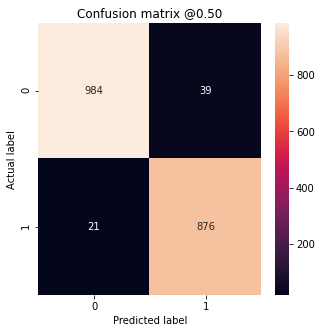

In [33]:
predict_on_test_dataset(saved_classifier, test_ds, BATCH_SIZE=BATCH_SIZE)